In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader

In [ ]:
from starccato_flow.data.toy_data import ToyData
from starccato_flow.data.ccsn_data import CCSNData
from starccato_flow.training.trainer import Trainer

/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
from starccato_flow.utils.defaults import DEVICE

### Dataset

In [3]:
train_dataset = ToyData(num_signals=1684, signal_length=256)
validation_dataset = ToyData(num_signals=round(1684 * 0.1), signal_length=256)

### Dataset Plots

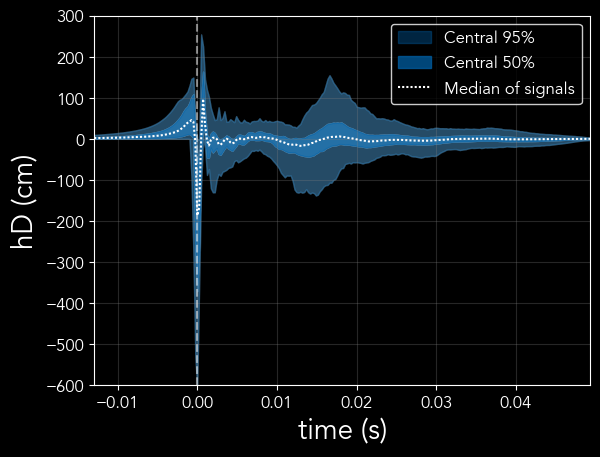

In [4]:
ccsn_dataset = CCSNData()
ccsn_dataset.plot_signal_distribution(background="black", font_family="sans-serif", font_name="Avenir")

In [5]:
toy=False

### Train VAE + Flow

Epochs:   1%|          | 1/128 [00:01<02:24,  1.14s/it]

Epoch 1/128 | Train Loss: 143.9138 | Val Loss: 112.4200


Epochs:   2%|▏         | 2/128 [00:01<01:55,  1.09it/s]

Epoch 2/128 | Train Loss: 96.0996 | Val Loss: 86.0096


Epochs:   2%|▏         | 3/128 [00:02<01:43,  1.21it/s]

Epoch 3/128 | Train Loss: 75.4843 | Val Loss: 67.3707


Epochs:   3%|▎         | 4/128 [00:03<01:42,  1.21it/s]

Epoch 4/128 | Train Loss: 64.9066 | Val Loss: 61.3722


Epochs:   4%|▍         | 5/128 [00:04<01:37,  1.26it/s]

Epoch 5/128 | Train Loss: 59.9656 | Val Loss: 56.7727


Epochs:   5%|▍         | 6/128 [00:04<01:30,  1.35it/s]

Epoch 6/128 | Train Loss: 55.9286 | Val Loss: 52.8552


Epochs:   5%|▌         | 7/128 [00:05<01:24,  1.42it/s]

Epoch 7/128 | Train Loss: 52.6077 | Val Loss: 50.0021


Epochs:   6%|▋         | 8/128 [00:06<01:20,  1.48it/s]

Epoch 8/128 | Train Loss: 48.4003 | Val Loss: 46.8188


Epochs:   7%|▋         | 9/128 [00:06<01:19,  1.50it/s]

Epoch 9/128 | Train Loss: 46.8883 | Val Loss: 45.4103


Epochs:   8%|▊         | 10/128 [00:07<01:16,  1.54it/s]

Epoch 10/128 | Train Loss: 44.7400 | Val Loss: 43.6532


Epochs:   9%|▊         | 11/128 [00:07<01:14,  1.56it/s]

Epoch 11/128 | Train Loss: 43.2159 | Val Loss: 43.5197


Epochs:   9%|▉         | 12/128 [00:08<01:13,  1.58it/s]

Epoch 12/128 | Train Loss: 43.0024 | Val Loss: 42.0527


Epochs:  10%|█         | 13/128 [00:09<01:11,  1.60it/s]

Epoch 13/128 | Train Loss: 41.4099 | Val Loss: 41.2532


Epochs:  11%|█         | 14/128 [00:09<01:11,  1.59it/s]

Epoch 14/128 | Train Loss: 40.7285 | Val Loss: 39.4783


Epochs:  12%|█▏        | 15/128 [00:10<01:10,  1.60it/s]

Epoch 15/128 | Train Loss: 40.6905 | Val Loss: 42.2541
Epoch 16/128 | Train Loss: 40.2521 | Val Loss: 38.7255


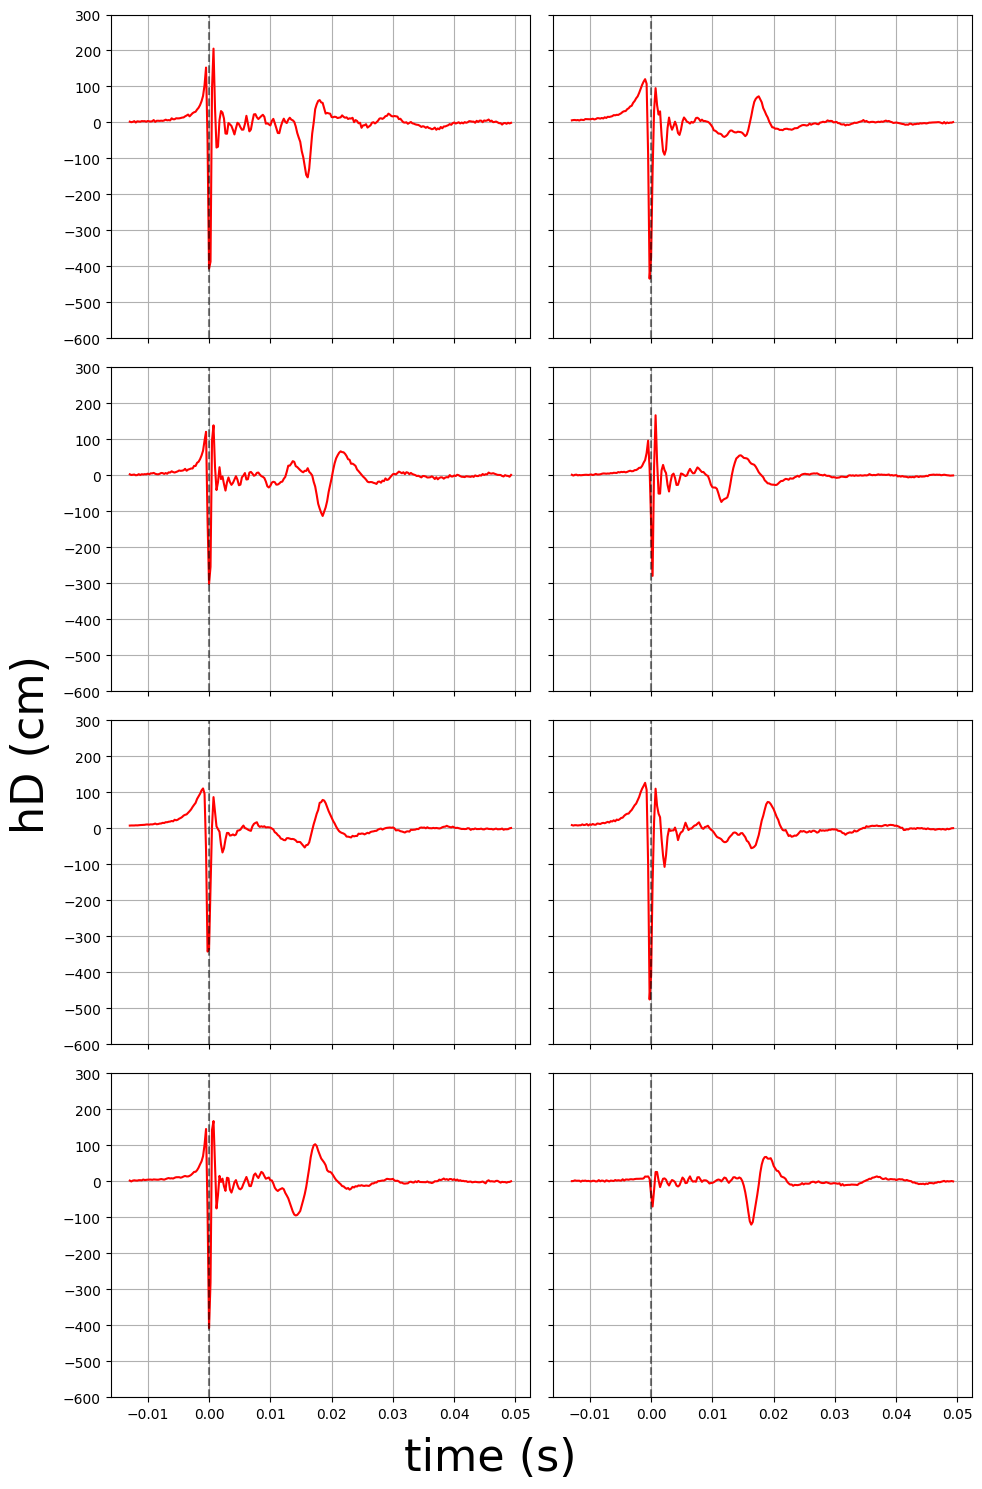

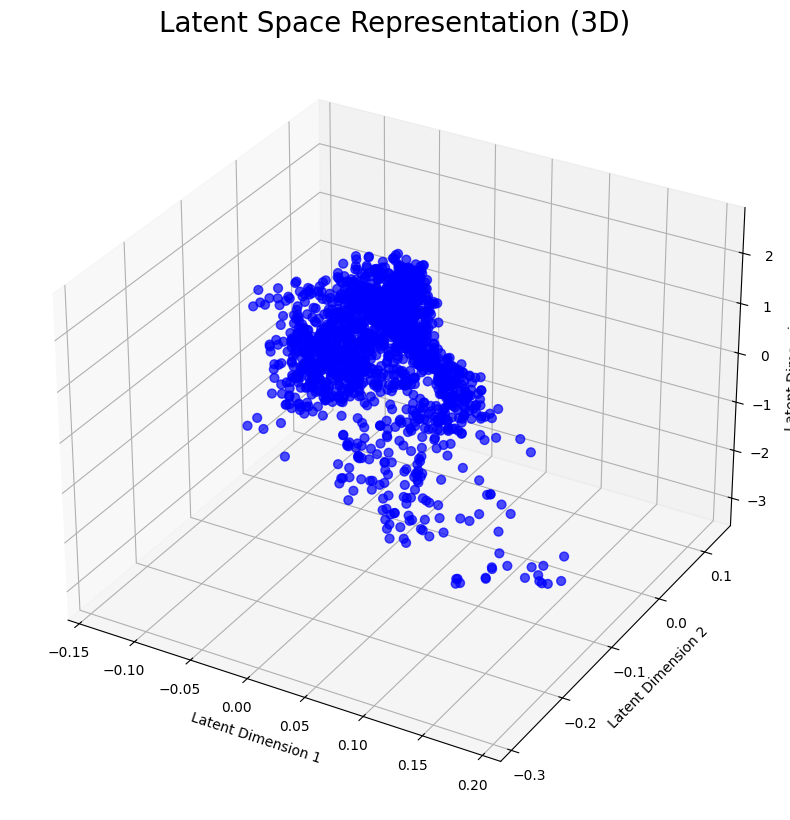

Epochs:  13%|█▎        | 17/128 [00:12<01:24,  1.32it/s]

Epoch 17/128 | Train Loss: 39.3685 | Val Loss: 38.1180


Epochs:  14%|█▍        | 18/128 [00:12<01:19,  1.39it/s]

Epoch 18/128 | Train Loss: 38.9412 | Val Loss: 38.8571


Epochs:  15%|█▍        | 19/128 [00:13<01:15,  1.45it/s]

Epoch 19/128 | Train Loss: 38.8850 | Val Loss: 39.0551


Epochs:  16%|█▌        | 20/128 [00:14<01:12,  1.49it/s]

Epoch 20/128 | Train Loss: 38.6899 | Val Loss: 38.8956


Epochs:  16%|█▋        | 21/128 [00:14<01:10,  1.53it/s]

Epoch 21/128 | Train Loss: 38.5049 | Val Loss: 38.9727


Epochs:  17%|█▋        | 22/128 [00:15<01:08,  1.55it/s]

Epoch 22/128 | Train Loss: 38.0576 | Val Loss: 37.0169


Epochs:  18%|█▊        | 23/128 [00:16<01:06,  1.57it/s]

Epoch 23/128 | Train Loss: 37.8227 | Val Loss: 36.8104


Epochs:  19%|█▉        | 24/128 [00:16<01:05,  1.59it/s]

Epoch 24/128 | Train Loss: 37.6268 | Val Loss: 36.7612


Epochs:  20%|█▉        | 25/128 [00:17<01:04,  1.60it/s]

Epoch 25/128 | Train Loss: 37.0063 | Val Loss: 37.0569


Epochs:  20%|██        | 26/128 [00:17<01:03,  1.60it/s]

Epoch 26/128 | Train Loss: 36.7774 | Val Loss: 36.1706


Epochs:  21%|██        | 27/128 [00:18<01:02,  1.61it/s]

Epoch 27/128 | Train Loss: 36.5976 | Val Loss: 35.5210


Epochs:  22%|██▏       | 28/128 [00:19<01:02,  1.61it/s]

Epoch 28/128 | Train Loss: 37.0965 | Val Loss: 36.4214


Epochs:  23%|██▎       | 29/128 [00:19<01:01,  1.61it/s]

Epoch 29/128 | Train Loss: 36.7398 | Val Loss: 36.4776


Epochs:  23%|██▎       | 30/128 [00:20<01:00,  1.62it/s]

Epoch 30/128 | Train Loss: 36.3875 | Val Loss: 34.9788


Epochs:  24%|██▍       | 31/128 [00:20<00:59,  1.62it/s]

Epoch 31/128 | Train Loss: 35.6966 | Val Loss: 34.9856
Epoch 32/128 | Train Loss: 35.9977 | Val Loss: 35.0067


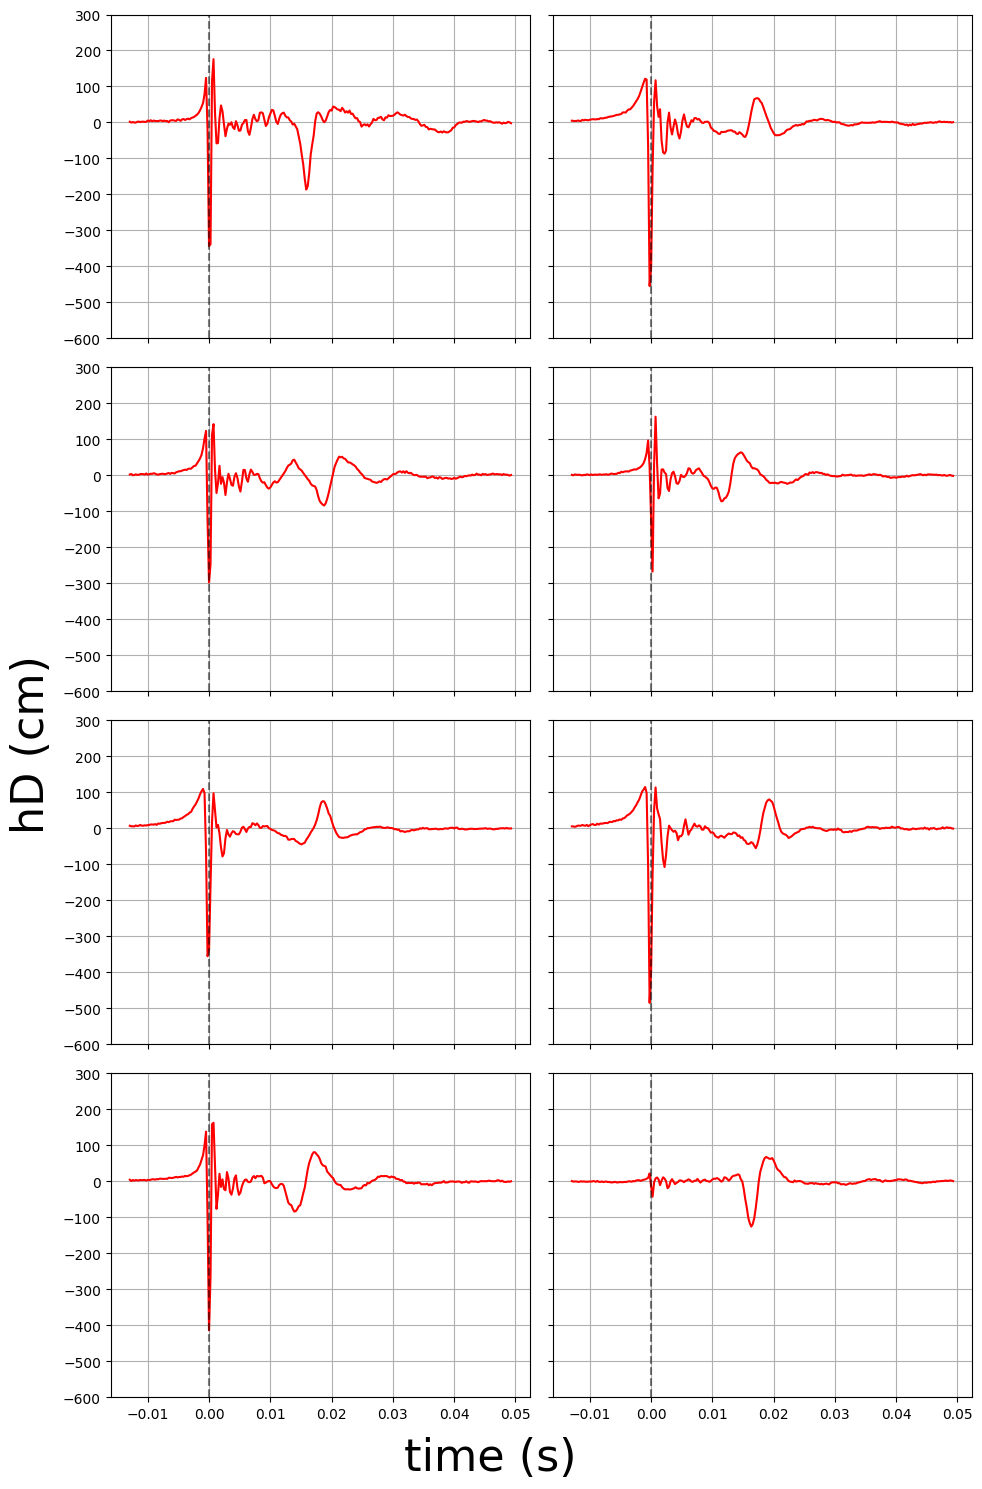

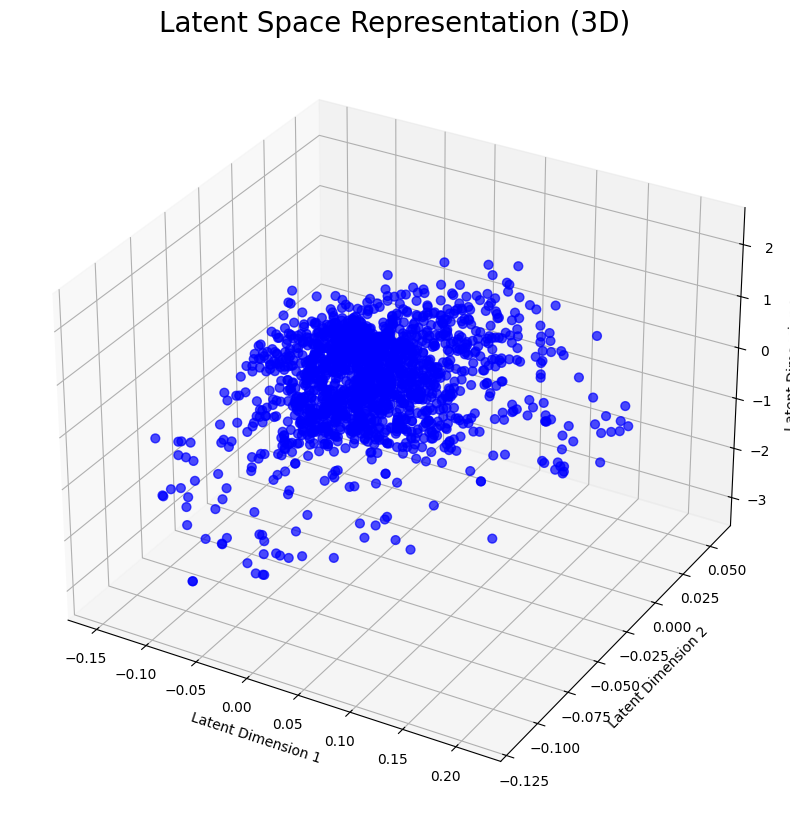

Epochs:  26%|██▌       | 33/128 [00:22<01:10,  1.36it/s]

Epoch 33/128 | Train Loss: 35.7071 | Val Loss: 35.0836


Epochs:  27%|██▋       | 34/128 [00:23<01:08,  1.38it/s]

Epoch 34/128 | Train Loss: 35.0114 | Val Loss: 34.9126


Epochs:  27%|██▋       | 35/128 [00:24<01:07,  1.39it/s]

Epoch 35/128 | Train Loss: 35.2860 | Val Loss: 35.1756


Epochs:  28%|██▊       | 36/128 [00:24<01:05,  1.41it/s]

Epoch 36/128 | Train Loss: 35.4701 | Val Loss: 34.7493


Epochs:  29%|██▉       | 37/128 [00:25<01:04,  1.40it/s]

Epoch 37/128 | Train Loss: 35.4035 | Val Loss: 34.9394


Epochs:  30%|██▉       | 38/128 [00:26<01:03,  1.41it/s]

Epoch 38/128 | Train Loss: 34.9370 | Val Loss: 34.7010


Epochs:  30%|███       | 39/128 [00:27<01:07,  1.33it/s]

Epoch 39/128 | Train Loss: 34.7169 | Val Loss: 34.0001


Epochs:  31%|███▏      | 40/128 [00:27<01:03,  1.39it/s]

Epoch 40/128 | Train Loss: 34.4021 | Val Loss: 34.6079


Epochs:  32%|███▏      | 41/128 [00:28<01:01,  1.42it/s]

Epoch 41/128 | Train Loss: 34.5714 | Val Loss: 33.8065


Epochs:  33%|███▎      | 42/128 [00:29<00:58,  1.47it/s]

Epoch 42/128 | Train Loss: 34.2035 | Val Loss: 34.1626


Epochs:  34%|███▎      | 43/128 [00:29<00:57,  1.47it/s]

Epoch 43/128 | Train Loss: 34.4146 | Val Loss: 34.7012


Epochs:  34%|███▍      | 44/128 [00:30<00:57,  1.45it/s]

Epoch 44/128 | Train Loss: 34.5526 | Val Loss: 34.2327


Epochs:  35%|███▌      | 45/128 [00:31<00:57,  1.44it/s]

Epoch 45/128 | Train Loss: 34.2620 | Val Loss: 33.3376


Epochs:  36%|███▌      | 46/128 [00:31<00:55,  1.47it/s]

Epoch 46/128 | Train Loss: 33.9426 | Val Loss: 33.1425


Epochs:  37%|███▋      | 47/128 [00:32<00:55,  1.47it/s]

Epoch 47/128 | Train Loss: 34.2072 | Val Loss: 33.8480
Epoch 48/128 | Train Loss: 33.7899 | Val Loss: 34.1121


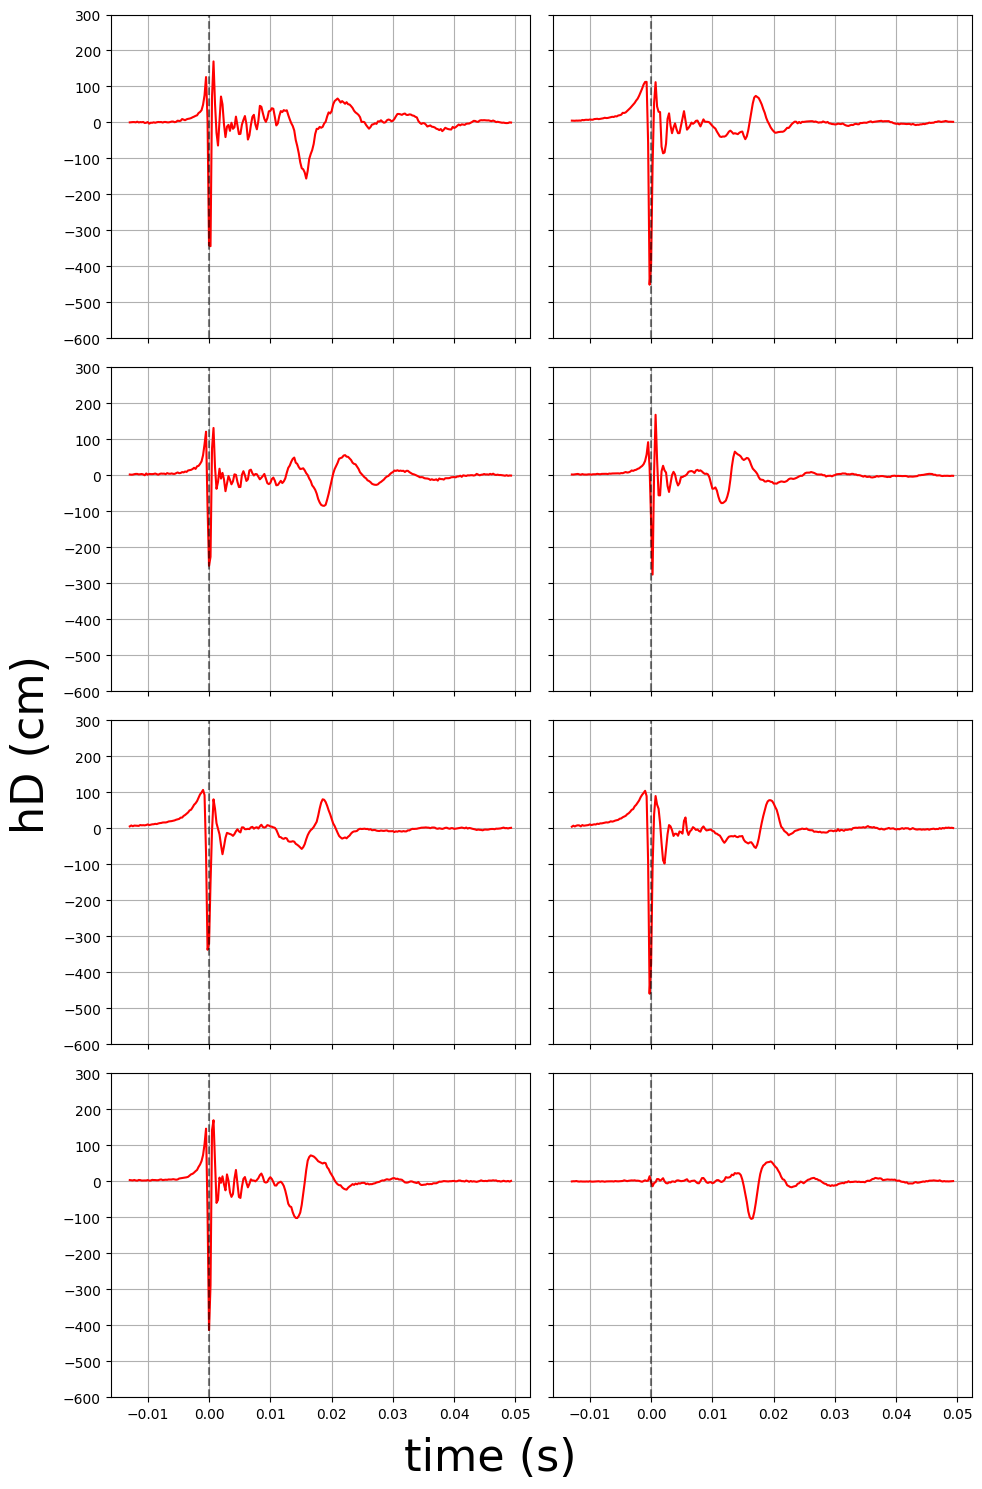

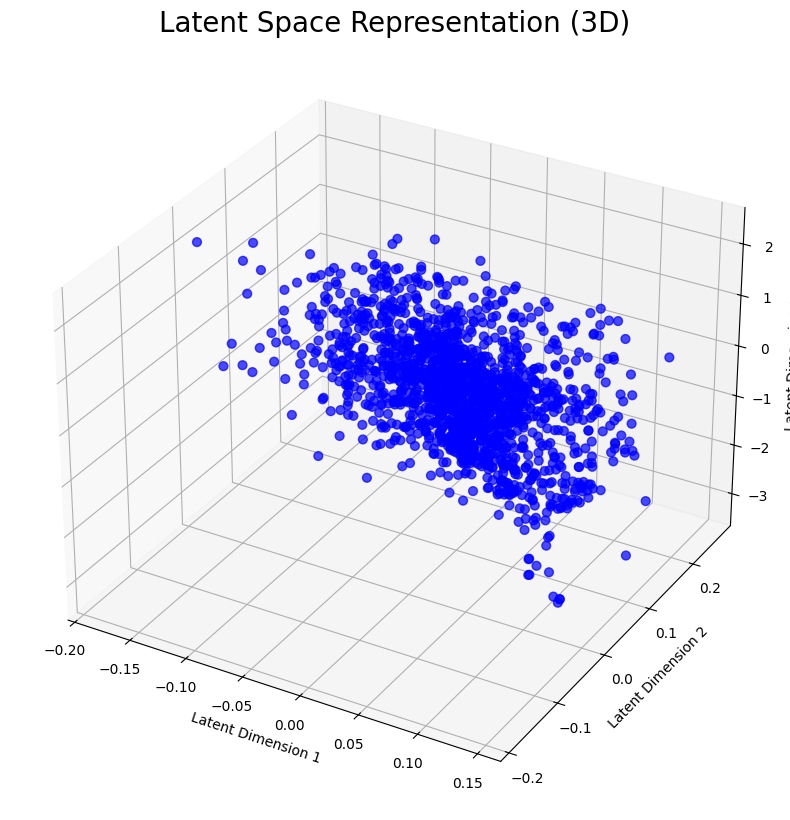

Epochs:  38%|███▊      | 49/128 [00:34<01:03,  1.24it/s]

Epoch 49/128 | Train Loss: 34.1418 | Val Loss: 33.2731


Epochs:  39%|███▉      | 50/128 [00:35<01:00,  1.29it/s]

Epoch 50/128 | Train Loss: 33.5649 | Val Loss: 33.2787


Epochs:  40%|███▉      | 51/128 [00:35<00:56,  1.36it/s]

Epoch 51/128 | Train Loss: 33.5869 | Val Loss: 33.8175


Epochs:  41%|████      | 52/128 [00:36<00:53,  1.42it/s]

Epoch 52/128 | Train Loss: 33.6152 | Val Loss: 33.5594


Epochs:  41%|████▏     | 53/128 [00:37<00:53,  1.41it/s]

Epoch 53/128 | Train Loss: 33.9119 | Val Loss: 32.3068


Epochs:  42%|████▏     | 54/128 [00:37<00:51,  1.43it/s]

Epoch 54/128 | Train Loss: 33.5685 | Val Loss: 33.5421


Epochs:  43%|████▎     | 55/128 [00:38<00:49,  1.46it/s]

Epoch 55/128 | Train Loss: 33.1990 | Val Loss: 32.6265


Epochs:  44%|████▍     | 56/128 [00:39<00:49,  1.46it/s]

Epoch 56/128 | Train Loss: 33.1497 | Val Loss: 32.3566


Epochs:  45%|████▍     | 57/128 [00:39<00:47,  1.50it/s]

Epoch 57/128 | Train Loss: 33.2085 | Val Loss: 33.3523


Epochs:  45%|████▌     | 58/128 [00:40<00:46,  1.49it/s]

Epoch 58/128 | Train Loss: 33.2483 | Val Loss: 32.0772


Epochs:  46%|████▌     | 59/128 [00:41<00:46,  1.50it/s]

Epoch 59/128 | Train Loss: 33.1643 | Val Loss: 32.1143


Epochs:  47%|████▋     | 60/128 [00:41<00:44,  1.53it/s]

Epoch 60/128 | Train Loss: 32.7081 | Val Loss: 32.7959


Epochs:  48%|████▊     | 61/128 [00:42<00:43,  1.56it/s]

Epoch 61/128 | Train Loss: 32.8496 | Val Loss: 32.2536


Epochs:  48%|████▊     | 62/128 [00:43<00:43,  1.51it/s]

Epoch 62/128 | Train Loss: 32.4001 | Val Loss: 32.6061


Epochs:  49%|████▉     | 63/128 [00:43<00:42,  1.55it/s]

Epoch 63/128 | Train Loss: 32.4612 | Val Loss: 31.9519
Epoch 64/128 | Train Loss: 32.3230 | Val Loss: 32.5331


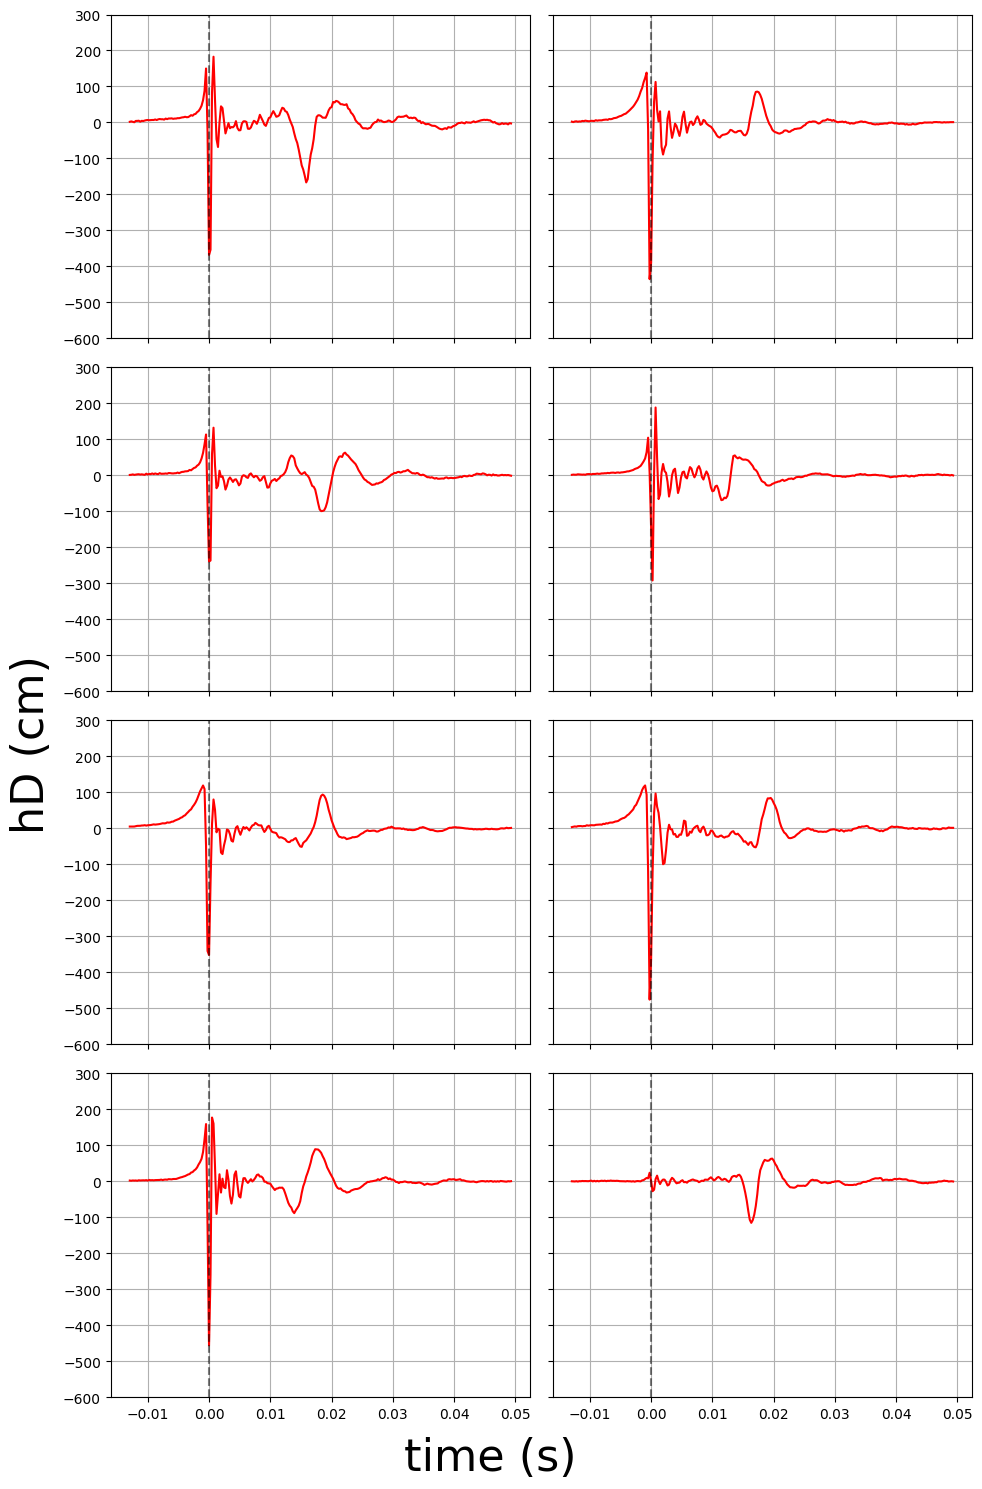

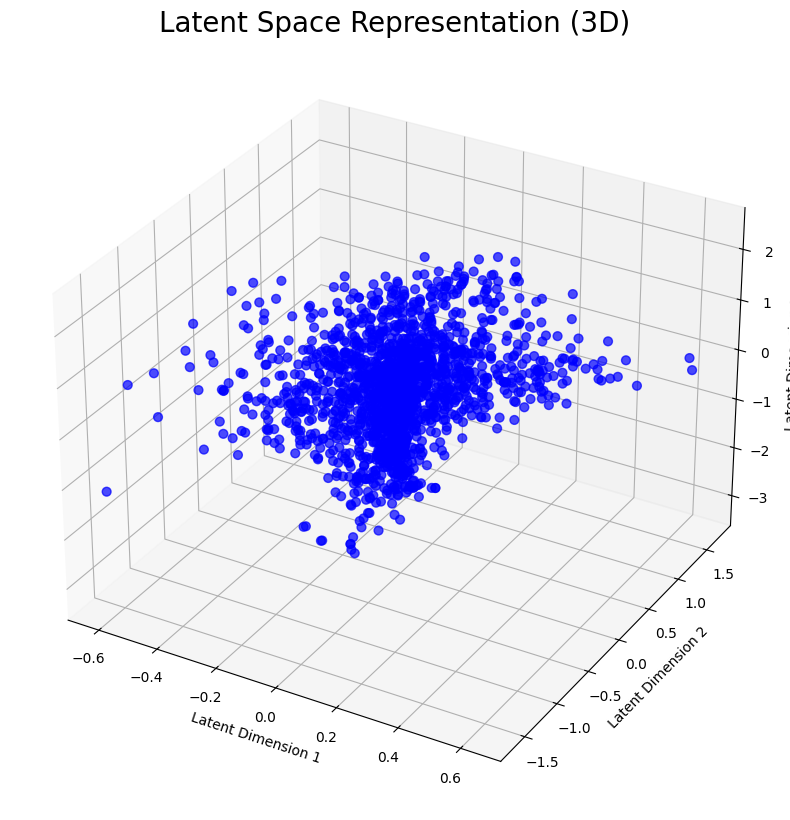

Epochs:  51%|█████     | 65/128 [00:45<00:46,  1.35it/s]

Epoch 65/128 | Train Loss: 32.5403 | Val Loss: 32.5968


Epochs:  52%|█████▏    | 66/128 [00:46<00:44,  1.40it/s]

Epoch 66/128 | Train Loss: 32.8899 | Val Loss: 31.8812


Epochs:  52%|█████▏    | 67/128 [00:46<00:41,  1.46it/s]

Epoch 67/128 | Train Loss: 32.1348 | Val Loss: 32.0820


Epochs:  53%|█████▎    | 68/128 [00:47<00:40,  1.50it/s]

Epoch 68/128 | Train Loss: 31.6782 | Val Loss: 31.6363


Epochs:  54%|█████▍    | 69/128 [00:47<00:38,  1.53it/s]

Epoch 69/128 | Train Loss: 32.1486 | Val Loss: 32.1562


Epochs:  55%|█████▍    | 70/128 [00:48<00:37,  1.56it/s]

Epoch 70/128 | Train Loss: 32.1486 | Val Loss: 31.5943


Epochs:  55%|█████▌    | 71/128 [00:49<00:36,  1.58it/s]

Epoch 71/128 | Train Loss: 31.7184 | Val Loss: 31.8556


Epochs:  56%|█████▋    | 72/128 [00:49<00:35,  1.59it/s]

Epoch 72/128 | Train Loss: 31.4975 | Val Loss: 31.1118


Epochs:  57%|█████▋    | 73/128 [00:50<00:34,  1.60it/s]

Epoch 73/128 | Train Loss: 31.6847 | Val Loss: 31.3868


Epochs:  58%|█████▊    | 74/128 [00:50<00:33,  1.61it/s]

Epoch 74/128 | Train Loss: 31.4181 | Val Loss: 30.3333


Epochs:  59%|█████▊    | 75/128 [00:51<00:33,  1.56it/s]

Epoch 75/128 | Train Loss: 31.5823 | Val Loss: 31.0862


Epochs:  59%|█████▉    | 76/128 [00:52<00:32,  1.58it/s]

Epoch 76/128 | Train Loss: 31.4130 | Val Loss: 31.2806


Epochs:  60%|██████    | 77/128 [00:52<00:31,  1.60it/s]

Epoch 77/128 | Train Loss: 31.0242 | Val Loss: 31.6416


Epochs:  61%|██████    | 78/128 [00:53<00:30,  1.61it/s]

Epoch 78/128 | Train Loss: 31.3824 | Val Loss: 30.9859


Epochs:  62%|██████▏   | 79/128 [00:54<00:30,  1.62it/s]

Epoch 79/128 | Train Loss: 31.2664 | Val Loss: 30.6819
Epoch 80/128 | Train Loss: 31.0953 | Val Loss: 30.3278


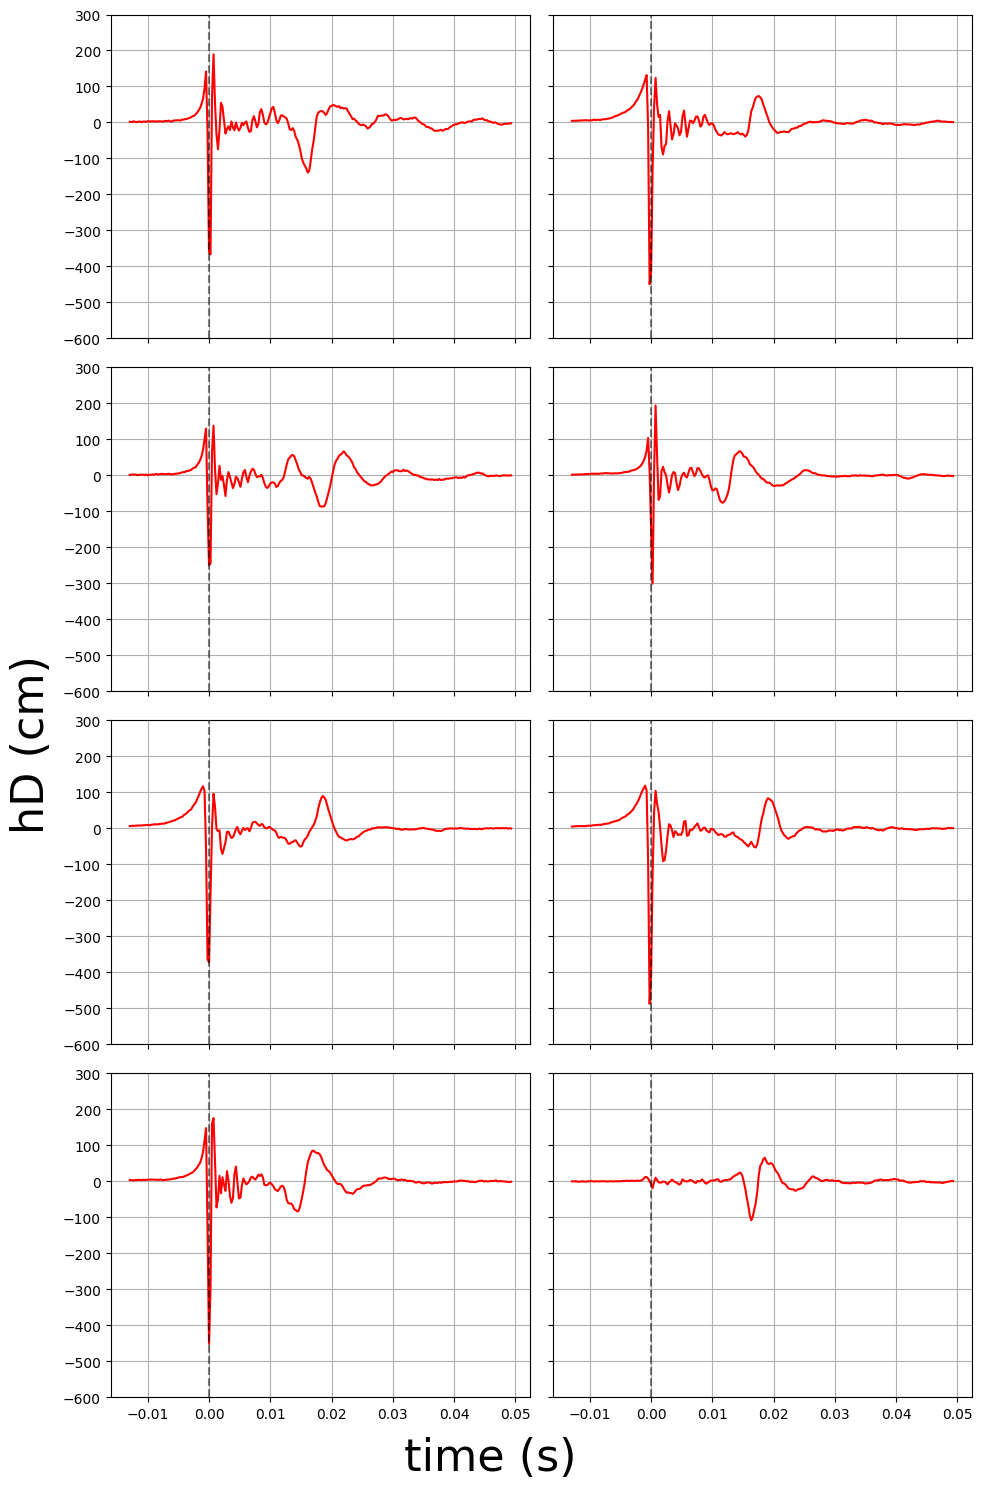

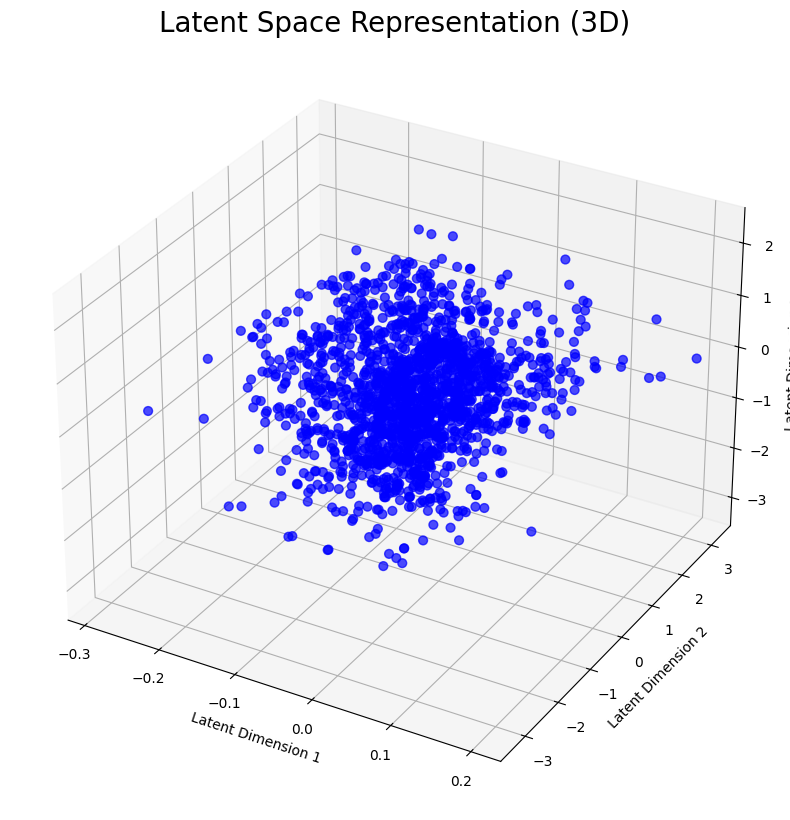

Epochs:  63%|██████▎   | 81/128 [00:55<00:33,  1.40it/s]

Epoch 81/128 | Train Loss: 30.8392 | Val Loss: 30.5931


Epochs:  64%|██████▍   | 82/128 [00:56<00:31,  1.44it/s]

Epoch 82/128 | Train Loss: 30.4210 | Val Loss: 30.4572


Epochs:  65%|██████▍   | 83/128 [00:57<00:31,  1.44it/s]

Epoch 83/128 | Train Loss: 30.6978 | Val Loss: 29.6785


Epochs:  66%|██████▌   | 84/128 [00:57<00:29,  1.48it/s]

Epoch 84/128 | Train Loss: 30.2372 | Val Loss: 29.6915


Epochs:  66%|██████▋   | 85/128 [00:58<00:31,  1.38it/s]

Epoch 85/128 | Train Loss: 30.7681 | Val Loss: 30.4065


Epochs:  67%|██████▋   | 86/128 [00:59<00:29,  1.40it/s]

Epoch 86/128 | Train Loss: 30.3617 | Val Loss: 29.5886


Epochs:  68%|██████▊   | 87/128 [00:59<00:28,  1.43it/s]

Epoch 87/128 | Train Loss: 30.4556 | Val Loss: 30.2227


Epochs:  69%|██████▉   | 88/128 [01:00<00:27,  1.46it/s]

Epoch 88/128 | Train Loss: 30.4802 | Val Loss: 29.9957


Epochs:  70%|██████▉   | 89/128 [01:01<00:26,  1.49it/s]

Epoch 89/128 | Train Loss: 30.0403 | Val Loss: 30.0502


Epochs:  70%|███████   | 90/128 [01:01<00:24,  1.52it/s]

Epoch 90/128 | Train Loss: 29.8537 | Val Loss: 29.0802


Epochs:  71%|███████   | 91/128 [01:02<00:25,  1.47it/s]

Epoch 91/128 | Train Loss: 29.5646 | Val Loss: 29.6539


Epochs:  72%|███████▏  | 92/128 [01:03<00:25,  1.43it/s]

Epoch 92/128 | Train Loss: 29.6895 | Val Loss: 28.9339


Epochs:  73%|███████▎  | 93/128 [01:04<00:24,  1.44it/s]

Epoch 93/128 | Train Loss: 29.7998 | Val Loss: 30.1545


Epochs:  73%|███████▎  | 94/128 [01:04<00:22,  1.48it/s]

Epoch 94/128 | Train Loss: 29.7031 | Val Loss: 29.1211


Epochs:  74%|███████▍  | 95/128 [01:05<00:22,  1.46it/s]

Epoch 95/128 | Train Loss: 29.5194 | Val Loss: 29.0096
Epoch 96/128 | Train Loss: 29.5956 | Val Loss: 29.5558


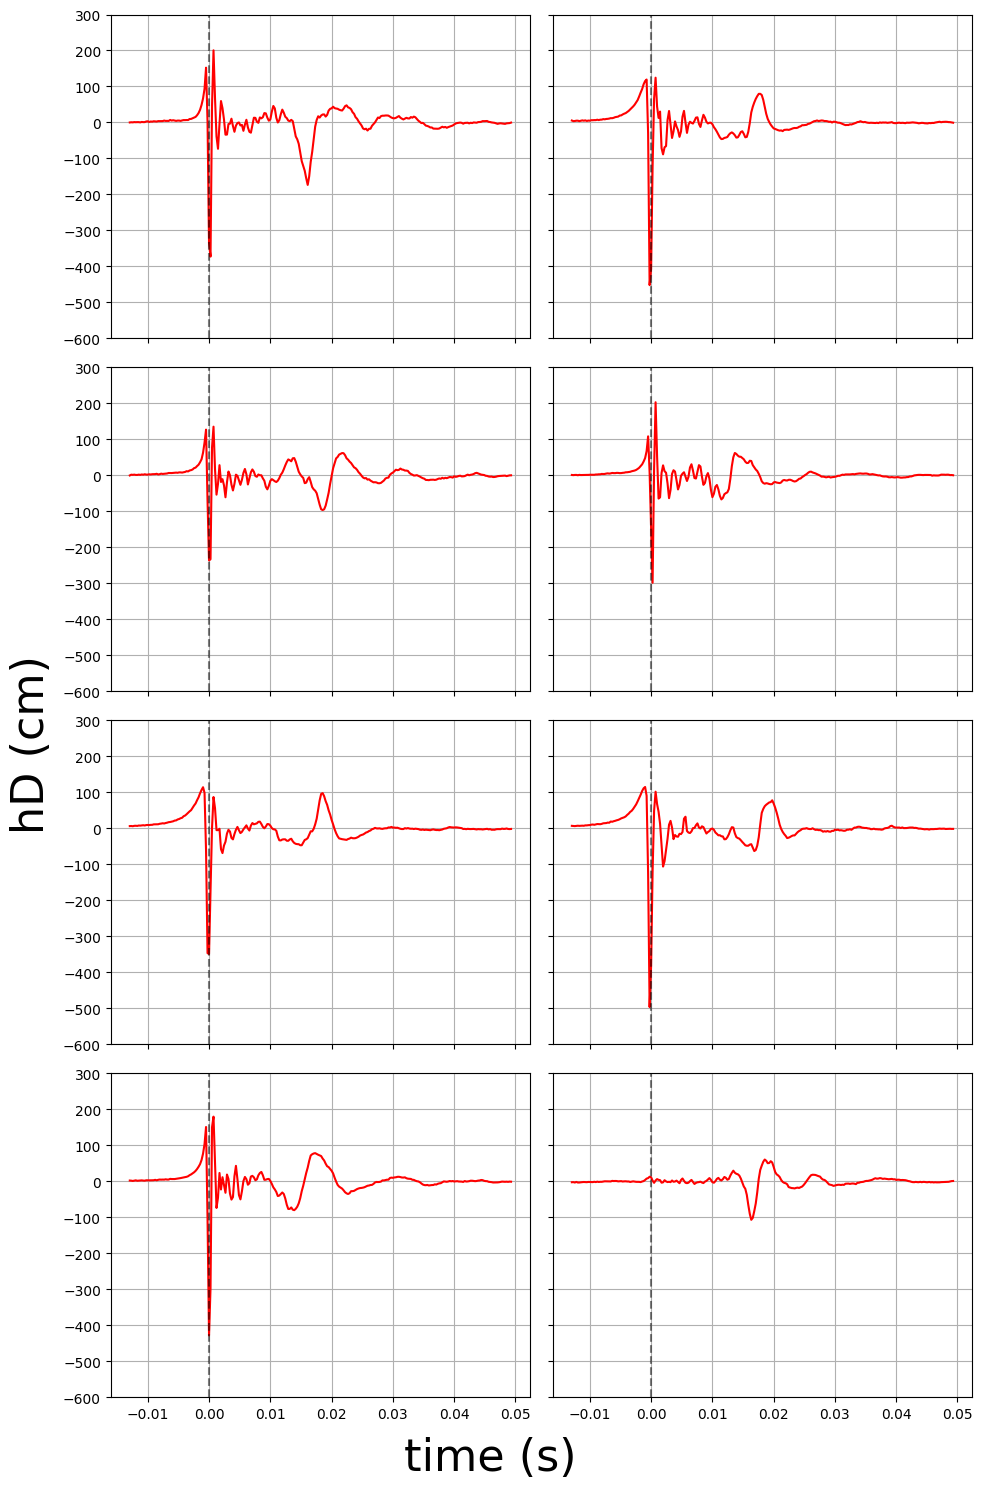

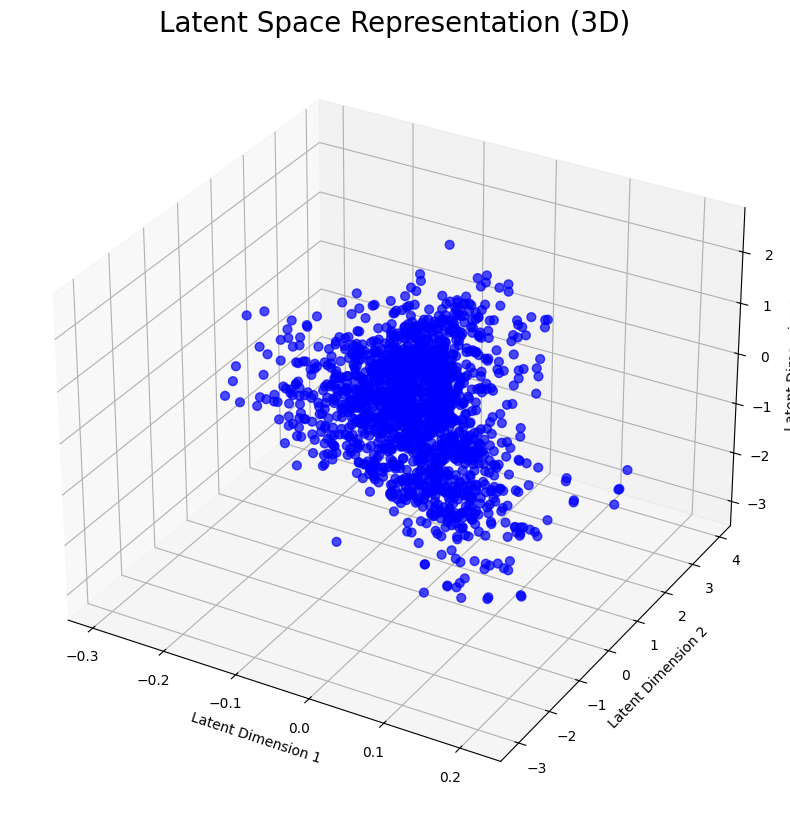

Epochs:  76%|███████▌  | 97/128 [01:07<00:23,  1.33it/s]

Epoch 97/128 | Train Loss: 29.8008 | Val Loss: 29.1919


Epochs:  77%|███████▋  | 98/128 [01:07<00:21,  1.40it/s]

Epoch 98/128 | Train Loss: 29.0135 | Val Loss: 28.2978


Epochs:  77%|███████▋  | 99/128 [01:08<00:19,  1.46it/s]

Epoch 99/128 | Train Loss: 29.3148 | Val Loss: 28.7329


Epochs:  78%|███████▊  | 100/128 [01:08<00:18,  1.51it/s]

Epoch 100/128 | Train Loss: 28.9951 | Val Loss: 29.3868


Epochs:  79%|███████▉  | 101/128 [01:09<00:17,  1.54it/s]

Epoch 101/128 | Train Loss: 29.0860 | Val Loss: 28.9216


Epochs:  80%|███████▉  | 102/128 [01:10<00:16,  1.56it/s]

Epoch 102/128 | Train Loss: 28.8697 | Val Loss: 28.8394


Epochs:  80%|████████  | 103/128 [01:10<00:15,  1.58it/s]

Epoch 103/128 | Train Loss: 29.0498 | Val Loss: 28.8426


Epochs:  81%|████████▏ | 104/128 [01:11<00:16,  1.49it/s]

Epoch 104/128 | Train Loss: 28.9038 | Val Loss: 28.7464


Epochs:  82%|████████▏ | 105/128 [01:12<00:15,  1.52it/s]

Epoch 105/128 | Train Loss: 29.1139 | Val Loss: 29.1733


Epochs:  83%|████████▎ | 106/128 [01:12<00:14,  1.53it/s]

Epoch 106/128 | Train Loss: 29.2350 | Val Loss: 29.4377


Epochs:  84%|████████▎ | 107/128 [01:13<00:13,  1.55it/s]

Epoch 107/128 | Train Loss: 29.2469 | Val Loss: 28.4725


Epochs:  84%|████████▍ | 108/128 [01:14<00:13,  1.51it/s]

Epoch 108/128 | Train Loss: 28.9911 | Val Loss: 28.8768


Epochs:  85%|████████▌ | 109/128 [01:14<00:12,  1.53it/s]

Epoch 109/128 | Train Loss: 28.8505 | Val Loss: 28.3353


Epochs:  86%|████████▌ | 110/128 [01:15<00:12,  1.40it/s]

Epoch 110/128 | Train Loss: 29.0756 | Val Loss: 28.1333


Epochs:  87%|████████▋ | 111/128 [01:16<00:12,  1.40it/s]

Epoch 111/128 | Train Loss: 28.6425 | Val Loss: 28.6391
Epoch 112/128 | Train Loss: 28.9532 | Val Loss: 28.8619


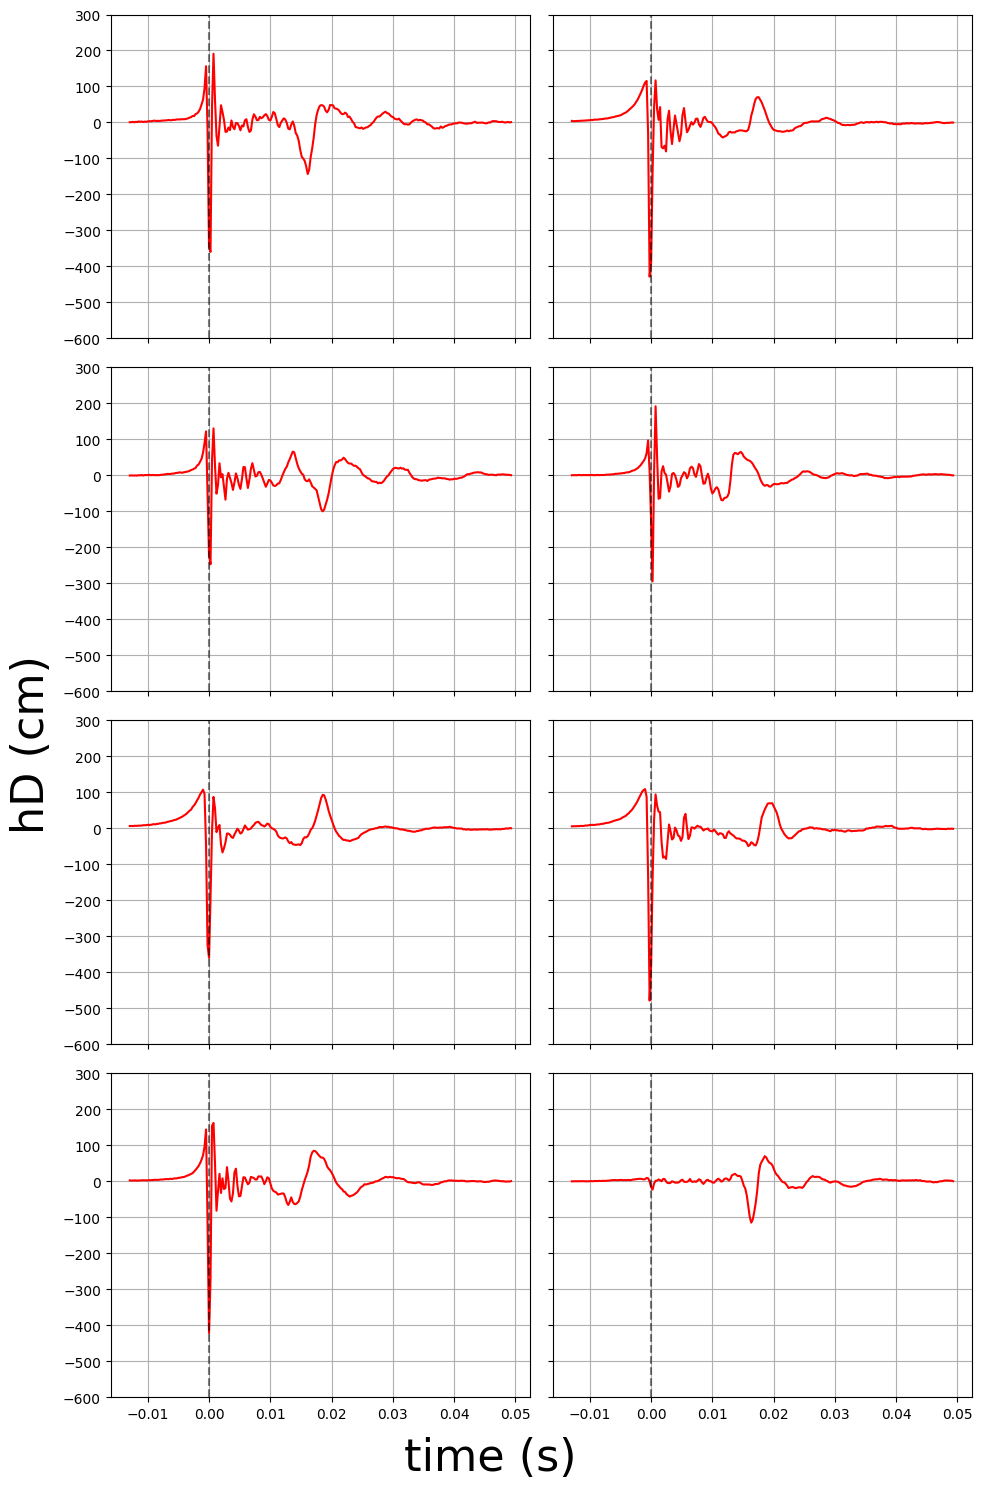

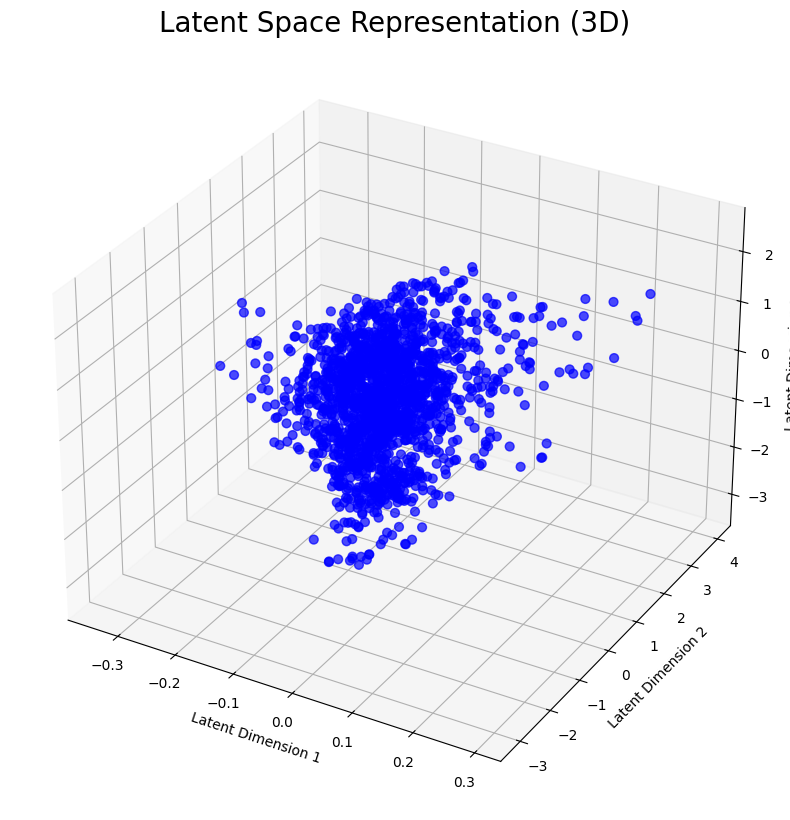

Epochs:  88%|████████▊ | 113/128 [01:18<00:12,  1.16it/s]

Epoch 113/128 | Train Loss: 28.6353 | Val Loss: 27.8046


Epochs:  89%|████████▉ | 114/128 [01:19<00:11,  1.19it/s]

Epoch 114/128 | Train Loss: 28.6706 | Val Loss: 28.4309


Epochs:  90%|████████▉ | 115/128 [01:19<00:10,  1.27it/s]

Epoch 115/128 | Train Loss: 28.6881 | Val Loss: 28.1040


Epochs:  91%|█████████ | 116/128 [01:20<00:08,  1.34it/s]

Epoch 116/128 | Train Loss: 28.2182 | Val Loss: 28.0642


Epochs:  91%|█████████▏| 117/128 [01:21<00:08,  1.31it/s]

Epoch 117/128 | Train Loss: 28.3474 | Val Loss: 28.0541


Epochs:  92%|█████████▏| 118/128 [01:22<00:07,  1.38it/s]

Epoch 118/128 | Train Loss: 28.2556 | Val Loss: 28.5003


Epochs:  93%|█████████▎| 119/128 [01:22<00:06,  1.41it/s]

Epoch 119/128 | Train Loss: 28.3893 | Val Loss: 27.6808


Epochs:  94%|█████████▍| 120/128 [01:23<00:05,  1.46it/s]

Epoch 120/128 | Train Loss: 28.2288 | Val Loss: 27.4525


Epochs:  95%|█████████▍| 121/128 [01:23<00:04,  1.49it/s]

Epoch 121/128 | Train Loss: 28.2259 | Val Loss: 27.7449


Epochs:  95%|█████████▌| 122/128 [01:24<00:04,  1.36it/s]

Epoch 122/128 | Train Loss: 28.2365 | Val Loss: 28.1809


Epochs:  96%|█████████▌| 123/128 [01:25<00:03,  1.36it/s]

Epoch 123/128 | Train Loss: 28.0358 | Val Loss: 27.9216


Epochs:  97%|█████████▋| 124/128 [01:26<00:02,  1.39it/s]

Epoch 124/128 | Train Loss: 27.8933 | Val Loss: 27.9136


Epochs:  98%|█████████▊| 125/128 [01:26<00:02,  1.45it/s]

Epoch 125/128 | Train Loss: 27.6385 | Val Loss: 27.1208


Epochs:  98%|█████████▊| 126/128 [01:27<00:01,  1.52it/s]

Epoch 126/128 | Train Loss: 27.9747 | Val Loss: 27.7091


Epochs:  99%|█████████▉| 127/128 [01:28<00:00,  1.55it/s]

Epoch 127/128 | Train Loss: 28.0388 | Val Loss: 27.8057
Epoch 128/128 | Train Loss: 27.9232 | Val Loss: 27.9099


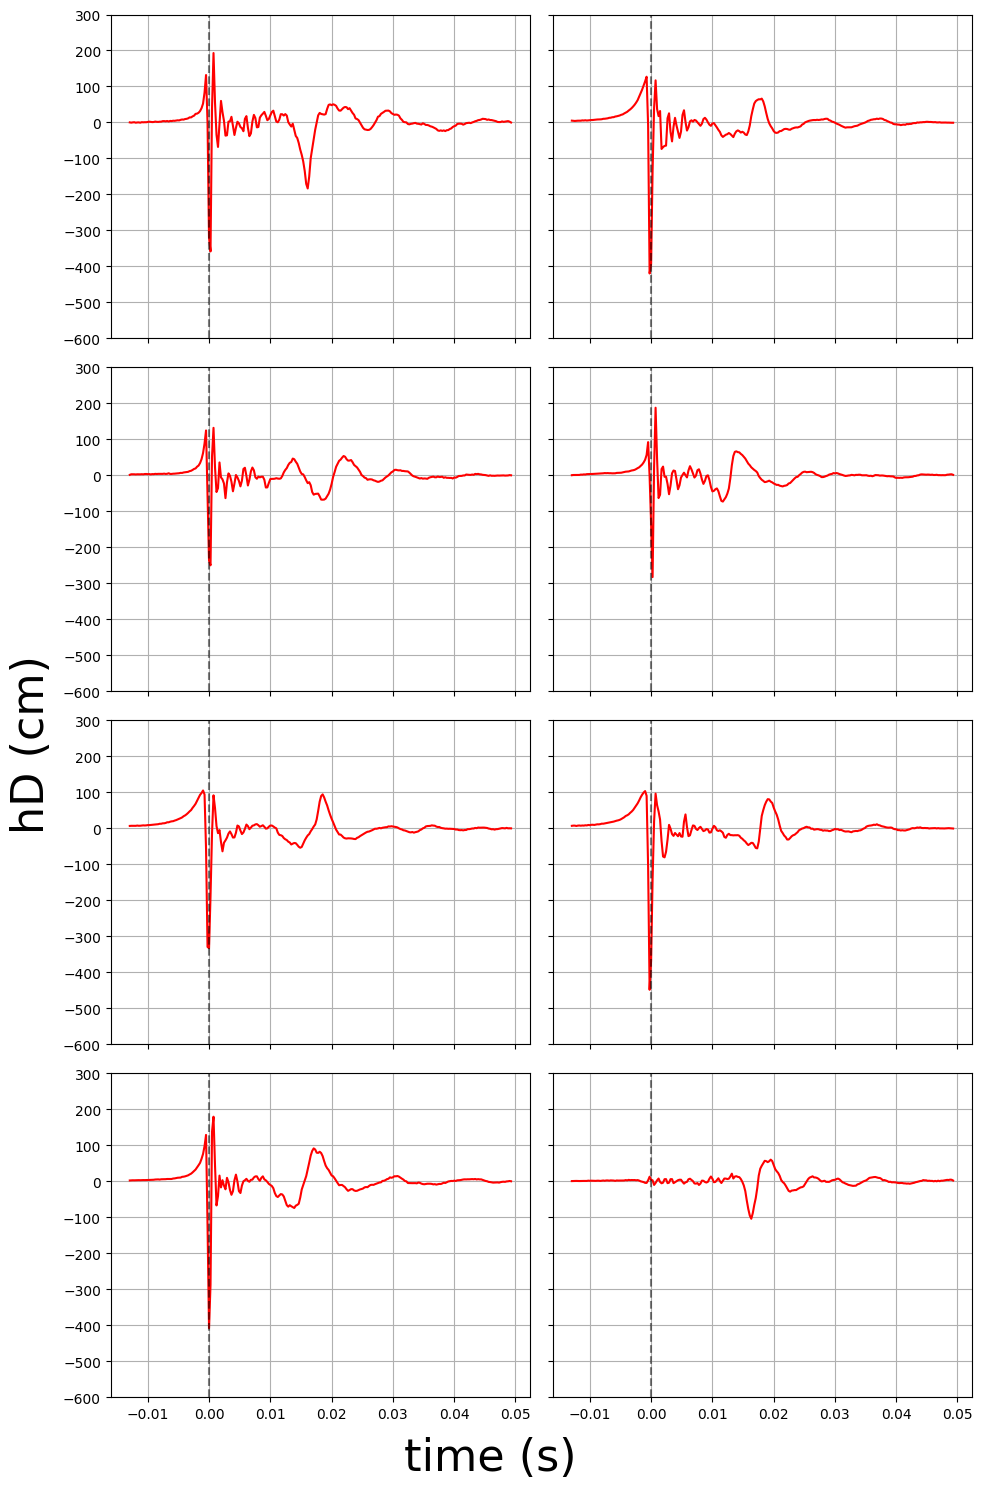

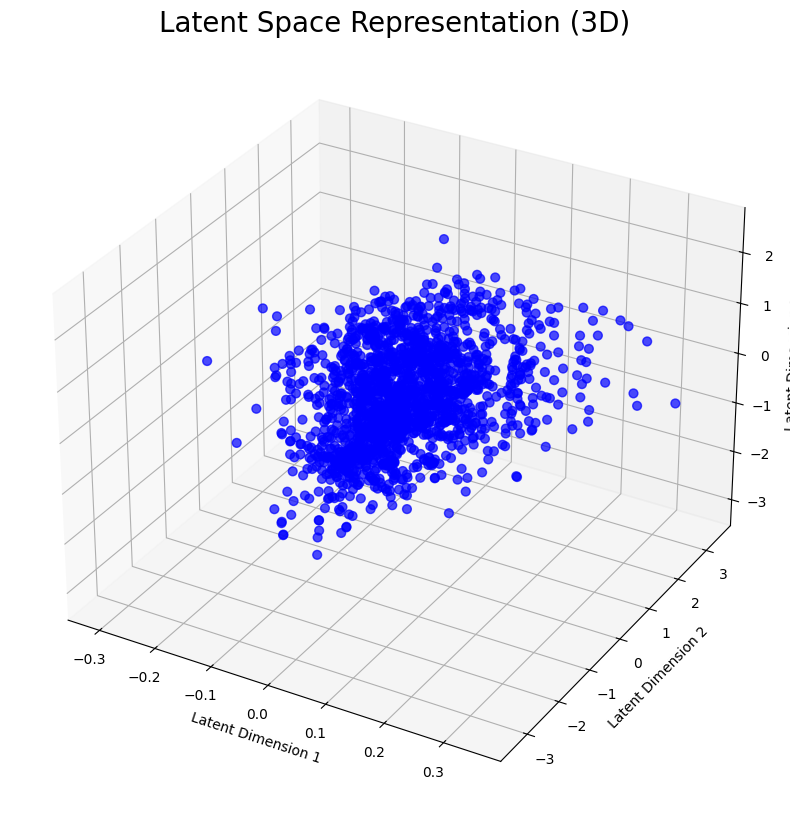

Epochs: 100%|██████████| 128/128 [01:29<00:00,  1.44it/s]

Training Time: 1.49min
Saved VAE model to outdir/generator_weights.pt


In [6]:
vae_trainer = Trainer(toy=toy)
vae_trainer.train()

### Display Results

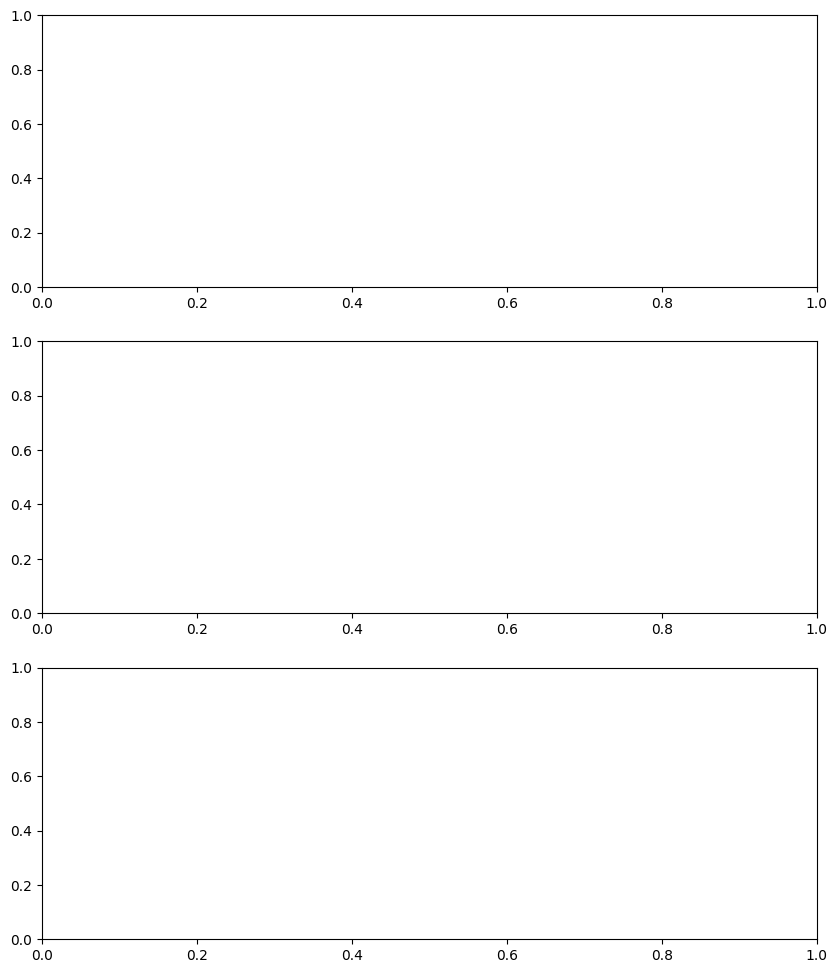

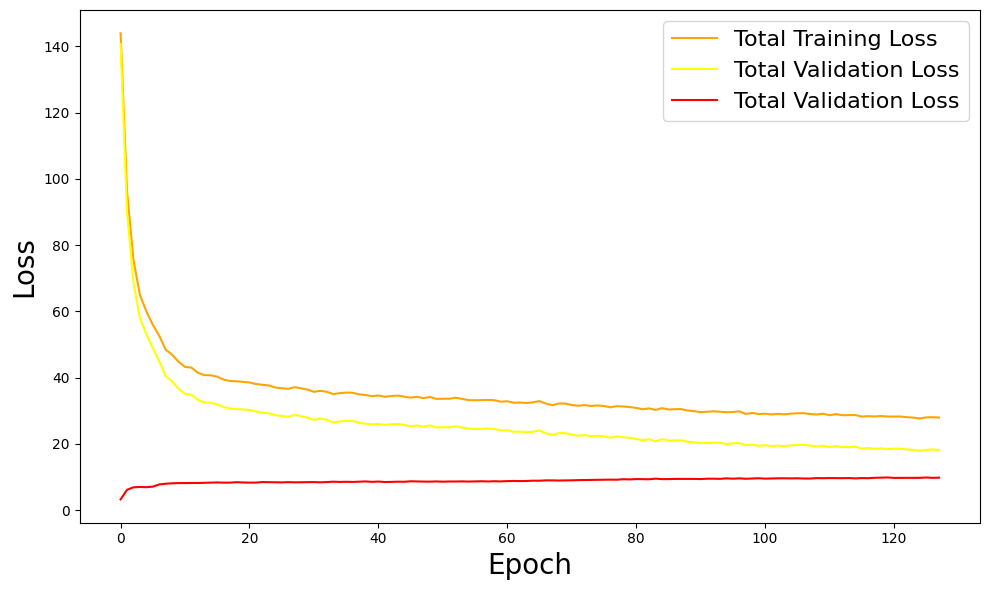

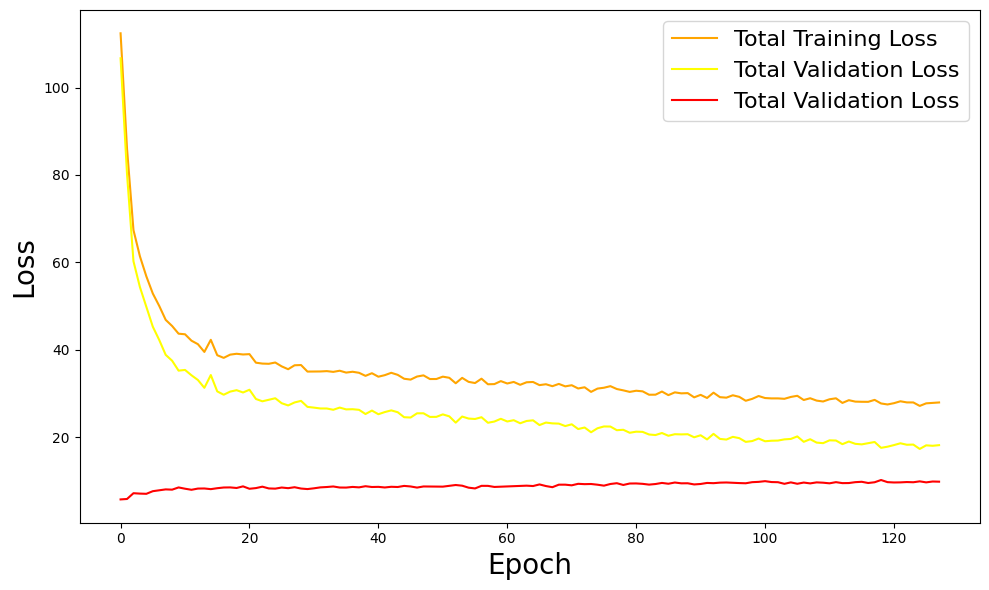

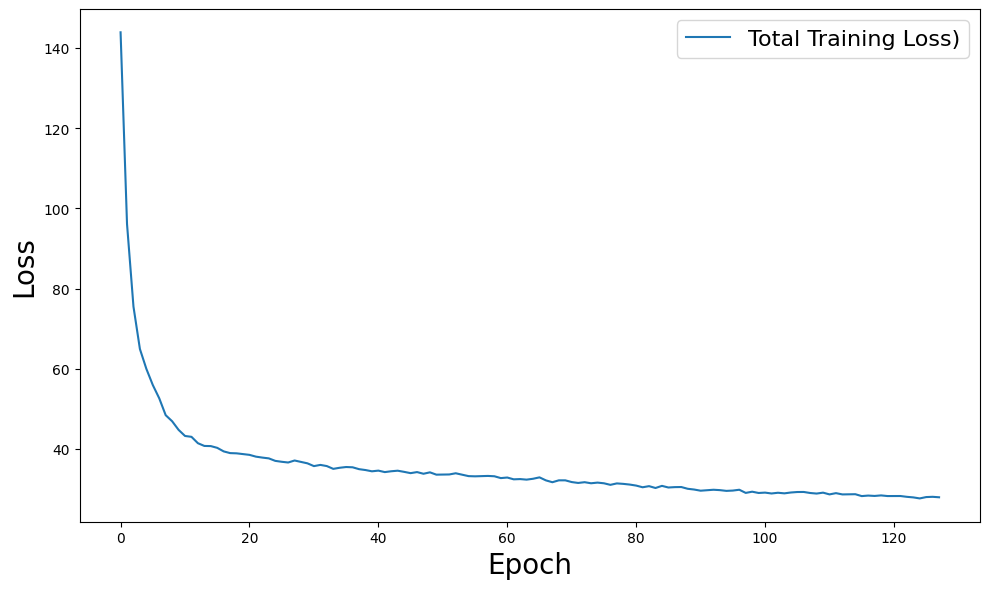

In [7]:
vae_trainer.display_results()

Execution Time: 0.18973493576049805 seconds


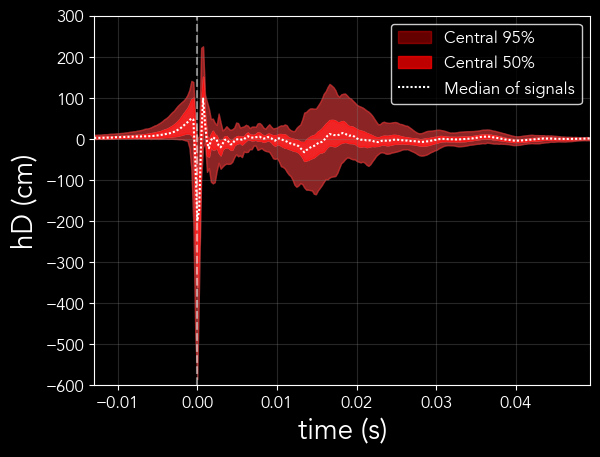

In [8]:
vae_trainer.plot_generated_signal_distribution(background="black", font_family="sans-serif", font_name="Avenir")

/var/folders/qy/p5knypnd54x1dfyxqbs0175r0000gn/T/ipykernel_70042/395226791.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(DEVICE)


IndexError: index 1 is out of bounds for dimension 0 with size 1

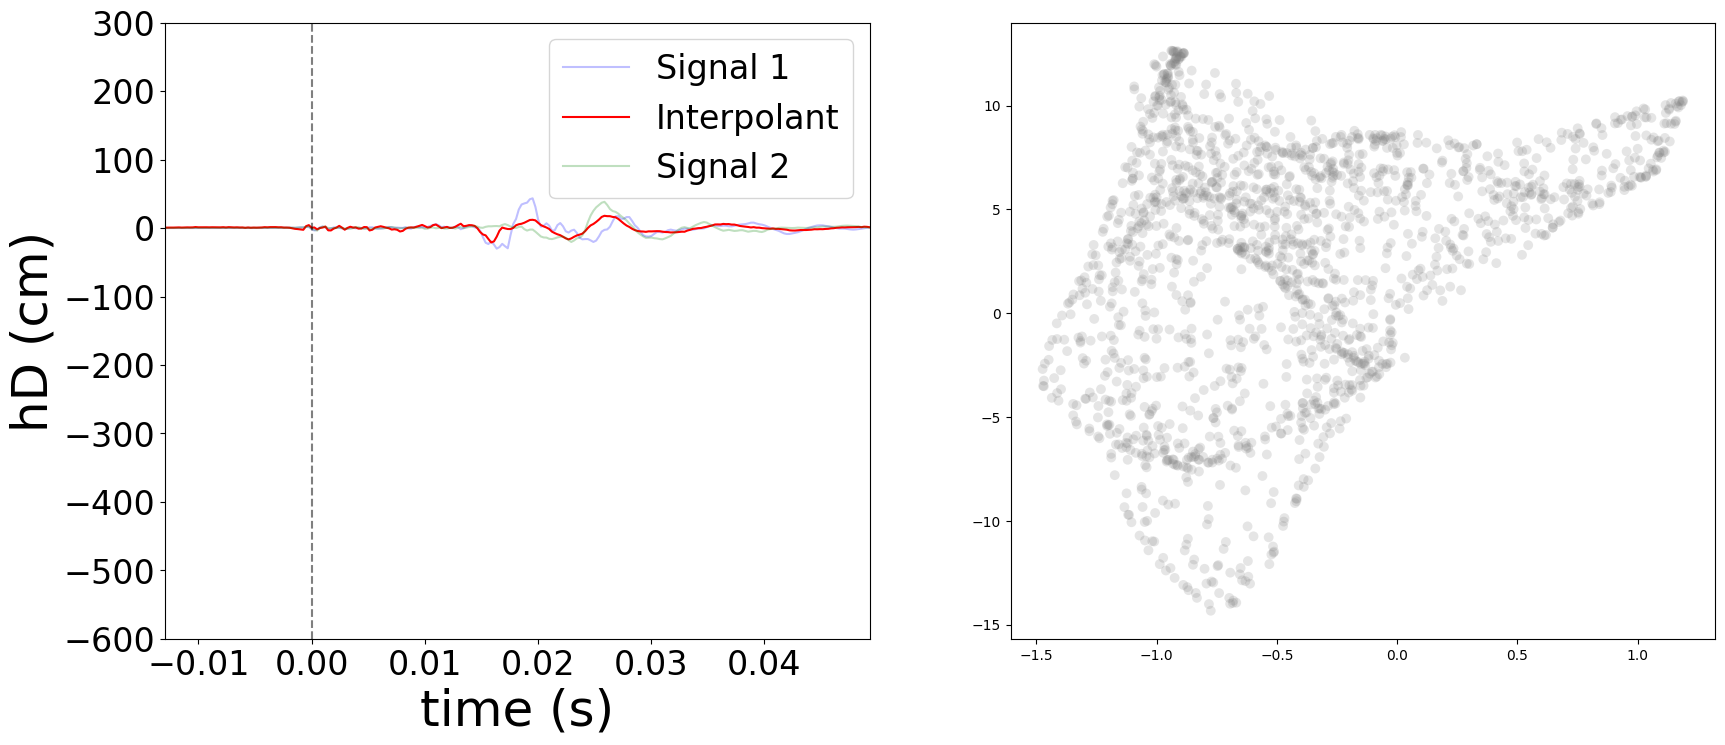

In [18]:
import matplotlib.pyplot as plt

def plot_latent_morph_side_by_side(
    model,
    signal_1: torch.Tensor,
    signal_2: torch.Tensor,
    max_value: float,
    train_dataset,
    steps=10
):
    model.eval()
    with torch.no_grad():
        # Encode signals
        mean_1, _ = model.encoder(signal_1)
        mean_2, _ = model.encoder(signal_2)

        # Get middle latent point
        alpha = 0.5
        mean_mid = mean_1 * (1 - alpha) + mean_2 * alpha
        signal_mid = model.decoder(mean_mid).cpu().detach().numpy().flatten() * max_value

        # Reconstruct signals
        signal_1_np = signal_1.cpu().detach().numpy().flatten() * max_value
        signal_2_np = signal_2.cpu().detach().numpy().flatten() * max_value

        # X-axis
        x_vals = [i / 4096 for i in range(0, 256)]
        x_vals = [x - (53 / 4096) for x in x_vals]

        # Posterior means for background latent scatter
        all_means = []
        for x, _ in train_dataset:
            x = torch.tensor(x).to(DEVICE)
            mean, _ = model.encoder(x)
            all_means.append(mean.cpu().numpy())
        all_means = np.concatenate(all_means, axis=0)

    # Set up figure
    fig = plt.figure(figsize=(20, 8))

    ax1 = fig.add_subplot(1, 2, 1)
    # plot all the signals on the plot
    ax1.plot(x_vals, signal_1_np, color='blue', label='Signal 1', alpha=0.25)
    ax1.plot(x_vals, signal_mid, color='red', label='Interpolant')
    ax1.plot(x_vals, signal_2_np, color='green', label='Signal 2', alpha=0.25)
    ax1.axvline(x=0, linestyle="--", color="black", alpha=0.5)
    ax1.set_ylim(-600, 300)
    ax1.set_xlim(left=x_vals[0], right=x_vals[-1])
    ax1.set_xlabel("time (s)", fontsize=36)
    ax1.set_ylabel("hD (cm)", fontsize=36)
    ax1.tick_params(axis='both', which='major', labelsize=24)
    ax1.grid(False)

    ax1.legend(loc='upper right', fontsize=24)

    # create the latent plot, but only use the first 2 dimensions
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(all_means[:, 0], all_means[:, 1], alpha=0.2, color='gray', edgecolors='none', s=50)
    ax2.plot(
        [mean_1[0].cpu(), mean_2[0].cpu()],
        [mean_1[1].cpu(), mean_2[1].cpu()],
        color='red', linestyle='--'
    )
    ax2.scatter(mean_1[0].cpu(), mean_1[1].cpu(), color='blue', label="Signal 1", alpha=0.25, edgecolors='none', s=50)
    ax2.scatter(mean_mid[0].cpu(), mean_mid[1].cpu(), color='red', label="Interpolant", edgecolors='none', s=50)
    ax2.scatter(mean_2[0].cpu(), mean_2[1].cpu(), color='green', label="Signal 2", alpha=0.25, edgecolors='none', s=50)
    ax2.set_xlabel('Latent Dim 1', fontsize=36)
    ax2.set_ylabel('Latent Dim 2', fontsize=36)
    ax2.tick_params(axis='both', which='major', labelsize=24)
    ax2.legend(loc='upper left', fontsize=24)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2)
    plt.savefig("latent_morph_side_by_side.pdf", dpi=300, bbox_inches='tight')

ccsn_signal_1 = ccsn_dataset.__getitem__(0)[0].to(DEVICE)
ccsn_signal_2 = ccsn_dataset.__getitem__(1)[0].to(DEVICE)

plot_latent_morph_side_by_side(
    vae_trainer.vae,
    signal_1=ccsn_signal_1,
    signal_2=ccsn_signal_2,
    max_value=train_dataset.max_strain,
    train_dataset=train_dataset,
    steps=1
)